# Shor's algorithm for factoring numbers
- It is a nice application of order-finding.
- We first check if N is even. If yes, return 2 as a factor.
- Else: a random integer $x \in [2, N-2]$ is chosen($0$ isn't coprime to $N$, and $1$ and $-1/N-1$ give trivial factors(i.e. $N$ itself)).
- If $\text{gcd}(x, N) > 1$, return $\gcd(x, N)$.
- Else: compute the order $r$ of $x$ modulo $N$. It is likely that $r$ is even and that $x^{r/2} \not\equiv -1 \pmod N$.
- If $r$ is indeed even and $x^{r/2} \not\equiv -1 \pmod N$, we have that $N$ divides the product $(x^{r/2} - 1) \cdot (x^{r/2} + 1)$ but does not fully divide any term. So we return $\gcd(x^{r/2} - 1, N)$ or $\gcd(x^{r/2} + 1, N)$ as a factor of $N$.
- Else the algorithm fails.
<br/>
<br/>
Finally, note that it is easy to see that we can use the factoring algorithm recursively (get one factor, divide $N$ by the factor and apply the algorithm on the quotient and so on) to get the full prime factorization of $N$(of course, we need some primality checks at each stage so that this terminates).

In [93]:
from qiskit import Aer, QuantumCircuit, transpile
sim = Aer.get_backend('aer_simulator')

from math import gcd, log2, ceil, pi

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [94]:
def find_order(x, N):
    """finds the order of x modulo N. x is assumed to be coprime to N"""
    assert(gcd(x, N) == 1)
    ...
# We must now implement the matrix U in phase estimation. Turns out this is not the easiest task and in general requires a O(L^3) qubits so even if N = 15, we get L^3 = 4^3 = 64 - a ton of qubits!
# so we implement a very special case of the order finding algorithm - it only works for N = 15 :). The following implementation for y_to_xy_mod15 is motivated by the qiskit docs.

def y_to_xy_mod15(x, power):
    assert(gcd(x, 15) == 1)
    # so x E 2,4,7, 8,11,13(x E [2,13])
    U = QuantumCircuit(4)
    
    def rotateleft(units: int):
        # if units == 0: do nothing
        if units == 1: U.swap(0, 1); U.swap(0, 2); U.swap(0, 3) # or equivalently swap(2, 3) then (1, 2) then (0, 1)
        elif units == 2: U.swap(0, 2); U.swap(1, 3)
        elif units == 3: U.swap(0, 3); U.swap(0, 2); U.swap(0, 1) # 3 left is the same as 1 right
    
    for _ in range(power):
        if x in [2, 13]: rotateleft(1)
        if x in [4, 11]: rotateleft(2)
        else: rotateleft(3) # x in [7, 8] now
        if x in [7, 11, 13]: U.x(range(4))

    return U.to_gate(label=f"  $U^{{{power}}}$  ")

In [95]:
# computes the fourier/inverse fourier transform of a set of sz qubits. Clearly the algorithm employs O(sz^2) gates.
def ft(sz: int, inverse=False):
    """Returns a fourier/inverse fourier transform gate. sz: number of qubits representing the state to take the fourier transform of."""
    ckt = QuantumCircuit(sz)
    sign = -1 if inverse else 1
    for i in range(sz): 
        ckt.h(i)
        for j in range(i+1, sz):
            ckt.cp(sign*pi/(2**(j-i)), i, j)
    for i in range(sz//2):
        ckt.swap(i, sz-1-i)
    return ckt.to_gate(label = (r"  $QFT^{\dagger}$  " if inverse else "  QFT  "))

[('00000', 239), ('11111', 217), ('10000', 203), ('01000', 115), ('01111', 104), ('10111', 20), ('01011', 16), ('10100', 15), ('11000', 15), ('01100', 14), ('01010', 14), ('11100', 10), ('01101', 7), ('01110', 7), ('11101', 6), ('11011', 5), ('01001', 4), ('10011', 3), ('11001', 3), ('10110', 2), ('10001', 2), ('11010', 1), ('10010', 1), ('11110', 1)]


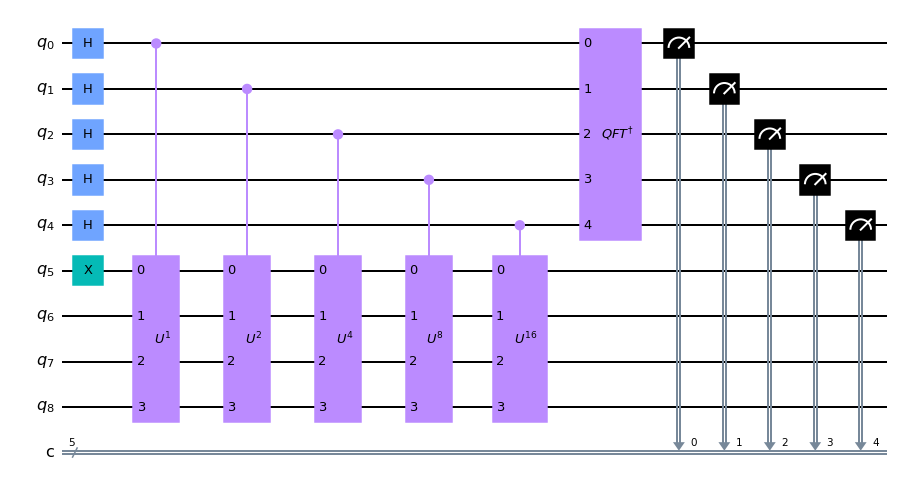

0.0


In [96]:
def estimate_phase(L: int, accuracy: int, epsilon: float, x: int):
    """phase estimation algorithm modified for factoring 15. L is the number of input qubits to U, accuracy is the number of bits of accuracy required in the phase, epsilon is the maximum probability of failure of the algorithm, x is the fixed x in - y_to_xy_mod15 takes |y> to |xy(15)> for all y E [15])"""

    t = accuracy + ceil(log2(2 + 1/(2*epsilon)))
    ckt = QuantumCircuit(t + L, t)

    # get superposition of all states |j> in the first register.
    ckt.h(range(t))

    # set the second register of L bits to |00..01> = |1>
    ckt.x(t) 

    # |j>|k> -> |j>| U^j|k> >
    for i in range(t): 
        ckt.append(y_to_xy_mod15(x, 2**i).control(num_ctrl_qubits=1), 
                [i] + list(range(t, t+L))) # the second argument qargs is the qubits to attach the instruction(gate) to.

    # take the inverse fourier transform of the first register.
    ckt = ckt.compose(ft(sz=t, inverse=True))

    # measure the first register to get the phase times 2^(sz of first register = t).
    ckt.measure(range(t), range(t))

    # finally, get the phase.
    results = sim.run(transpile(ckt, sim), shots=1024).result().get_counts()
    print(sorted(results.items(), key=lambda item: item[1], reverse=True))
    phase = int(sorted(results.items(), key=lambda item: item[1], reverse=True)[0][0], 2)/2**t
    return ckt, phase

ckt, phase = estimate_phase(L=4, accuracy=2, epsilon=0.1, x=7)
ckt.draw("mpl")
print(phase)